### Zbiór win
https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009?resource=download

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression 
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, precision_score, roc_auc_score,plot_roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import recall_score

In [2]:
df=pd.read_csv("winequality-red.csv")

In [30]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Analiza wstępna
- 11 kolumn ze zmiennymi objaśniającymi  (np. zawartość kwasu cytrynowego, gęstość, siarczany, alkohol) 
- kolumna "quality" - target (6 kategorii - od 3 do 8) 
- wszystkie zmienne ją wartościami numerycznymi

### Do sprawdzenia
- sprawdzić czy są wartości NaN lub 0
- określić outliery dla zbioru
- zastanowić się nad przypisaniem nowych kategorii dla targetu 'quality' (czy zmienić na binarne, jeśli tak to jak podzielić)
- zrobić wykresy typu: histogram, boxplot, rozkłady zmiennych
- sprawdzić korelacje


In [17]:
df.quality.value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [16]:
#wielkosc grup decyzyjnych
df.quality.value_counts()/sum(df.quality.value_counts())

5    0.425891
6    0.398999
7    0.124453
4    0.033146
8    0.011257
3    0.006254
Name: quality, dtype: float64

In [3]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


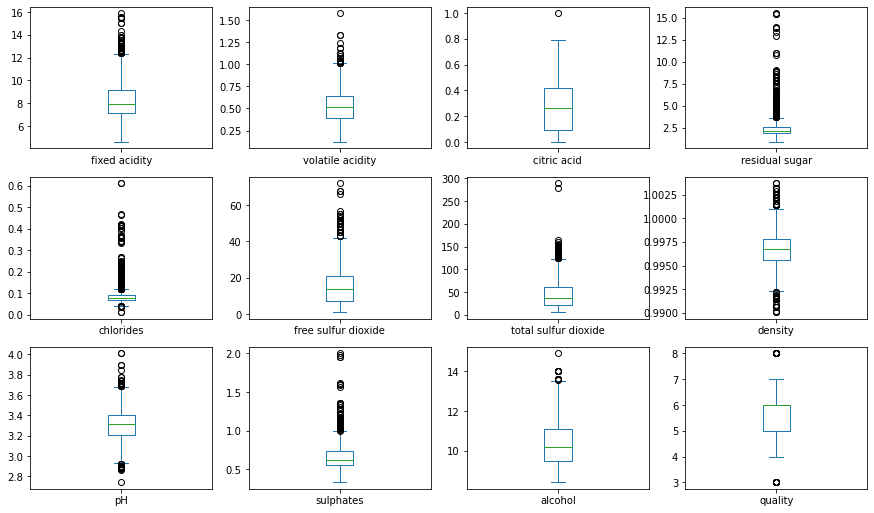

In [18]:
df.plot(kind= 'box' , 
        subplots=True, 
        layout=(4,4), 
        figsize=(15,12));

In [36]:
df['citric acid'][df['citric acid'] == 0].count()

132

#### Wartość 0 w przypadku kwasu cytrynowego nie jest błędna, jest to uproszczenie stosowane dla  substacji na śladowym poziomie stężenia

In [37]:
columns = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality']


In [38]:
def rm_out(df):
    df_out = df.copy()
    means, stdevs = {}, {}
    for column in df_out.columns:
        means[column] = df_out[column].mean()
        stdevs[column] = df_out[column].std()
    for column in df_out.columns:
        lower = means[column] - 3 * stdevs[column]
        upper = means[column] + 3 * stdevs[column]
        index = (lower < df_out[column]) & (df_out[column] < upper)
        df_out = df_out[index]
    df_out.index = range(len(df_out))
    return df_out

In [39]:
df_rm = rm_out(df[columns])

In [40]:
df_rm.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000,1451.000000
mean,8.310062,0.522950,0.265382,2.387285,0.081425,15.104755,43.735355,0.996710,3.315934,0.642584,10.421089,5.659545
std,1.646458,0.168531,0.190934,0.862078,0.020966,9.309768,29.441284,0.001716,0.141096,0.129801,1.021588,0.781605
min,5.000000,0.120000,0.000000,1.200000,0.038000,1.000000,6.000000,0.991500,2.880000,0.330000,8.500000,4.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,21.000000,0.995600,3.220000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,36.000000,0.996700,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.630000,0.420000,2.600000,0.089000,21.000000,58.000000,0.997800,3.400000,0.720000,11.100000,6.000000
max,13.500000,1.040000,0.790000,6.700000,0.226000,47.000000,145.000000,1.002200,3.750000,1.160000,13.600000,8.000000


#### usunięta została kategoria "quality = 3" ale było jej tylko 10 przypadków (0,6%)

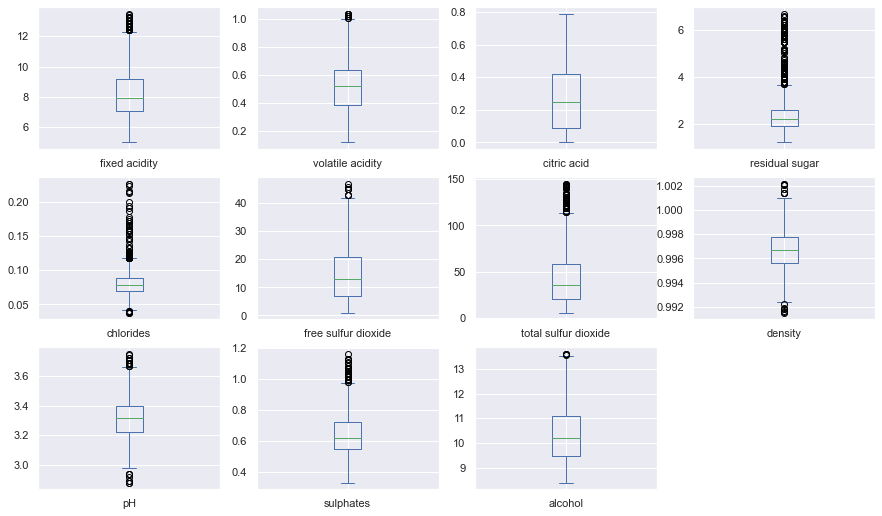

In [28]:
df_rm.plot(kind= 'box' , 
        subplots=True, 
        layout=(4,4), 
        figsize=(15,12));

<AxesSubplot:>

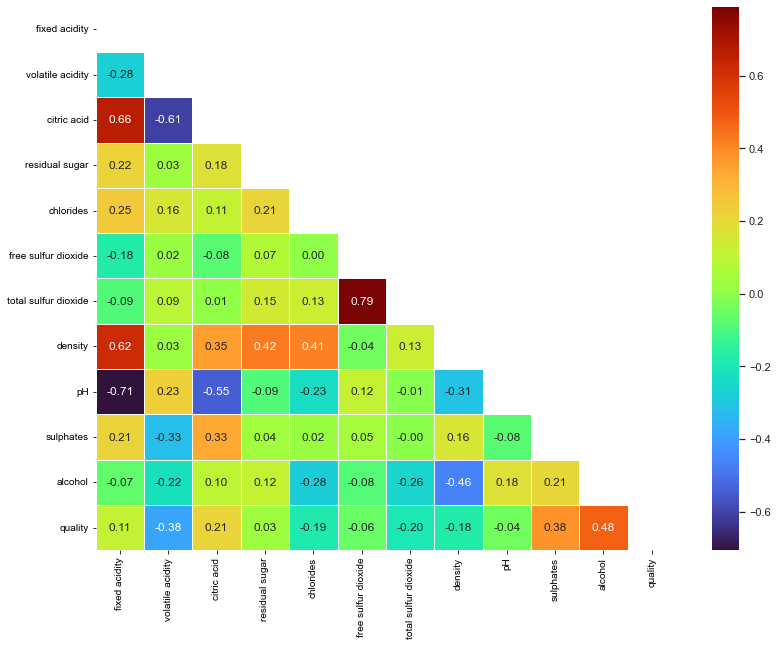

In [20]:
f,ax = plt.subplots(figsize=(13,10))
mask = np.triu(np.ones_like(df.corr(method='spearman')), k=0)
sns.set(font_scale=1)
sns.heatmap(df.corr(method='spearman'), annot=True, linewidths=1, fmt='.2f', ax=ax, cmap="turbo", annot_kws={'fontsize':12}, mask=mask)
  

<AxesSubplot:>

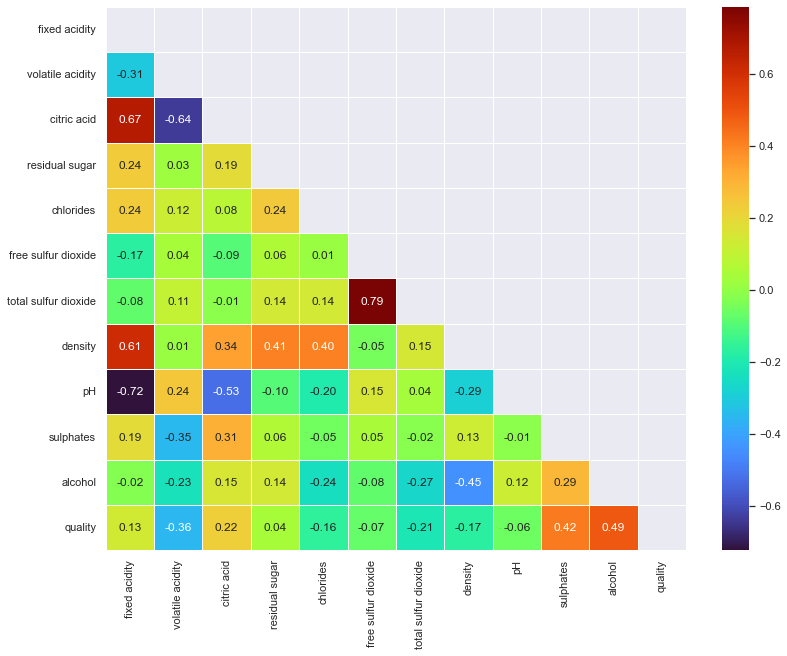

In [21]:
f,ax = plt.subplots(figsize=(13,10))
mask = np.triu(np.ones_like(df_rm.corr(method='spearman')), k=0)
sns.set(font_scale=1)
sns.heatmap(df_rm.corr(method='spearman'), annot=True, linewidths=1, fmt='.2f', ax=ax, cmap="turbo", annot_kws={'fontsize':12}, mask=mask)
  

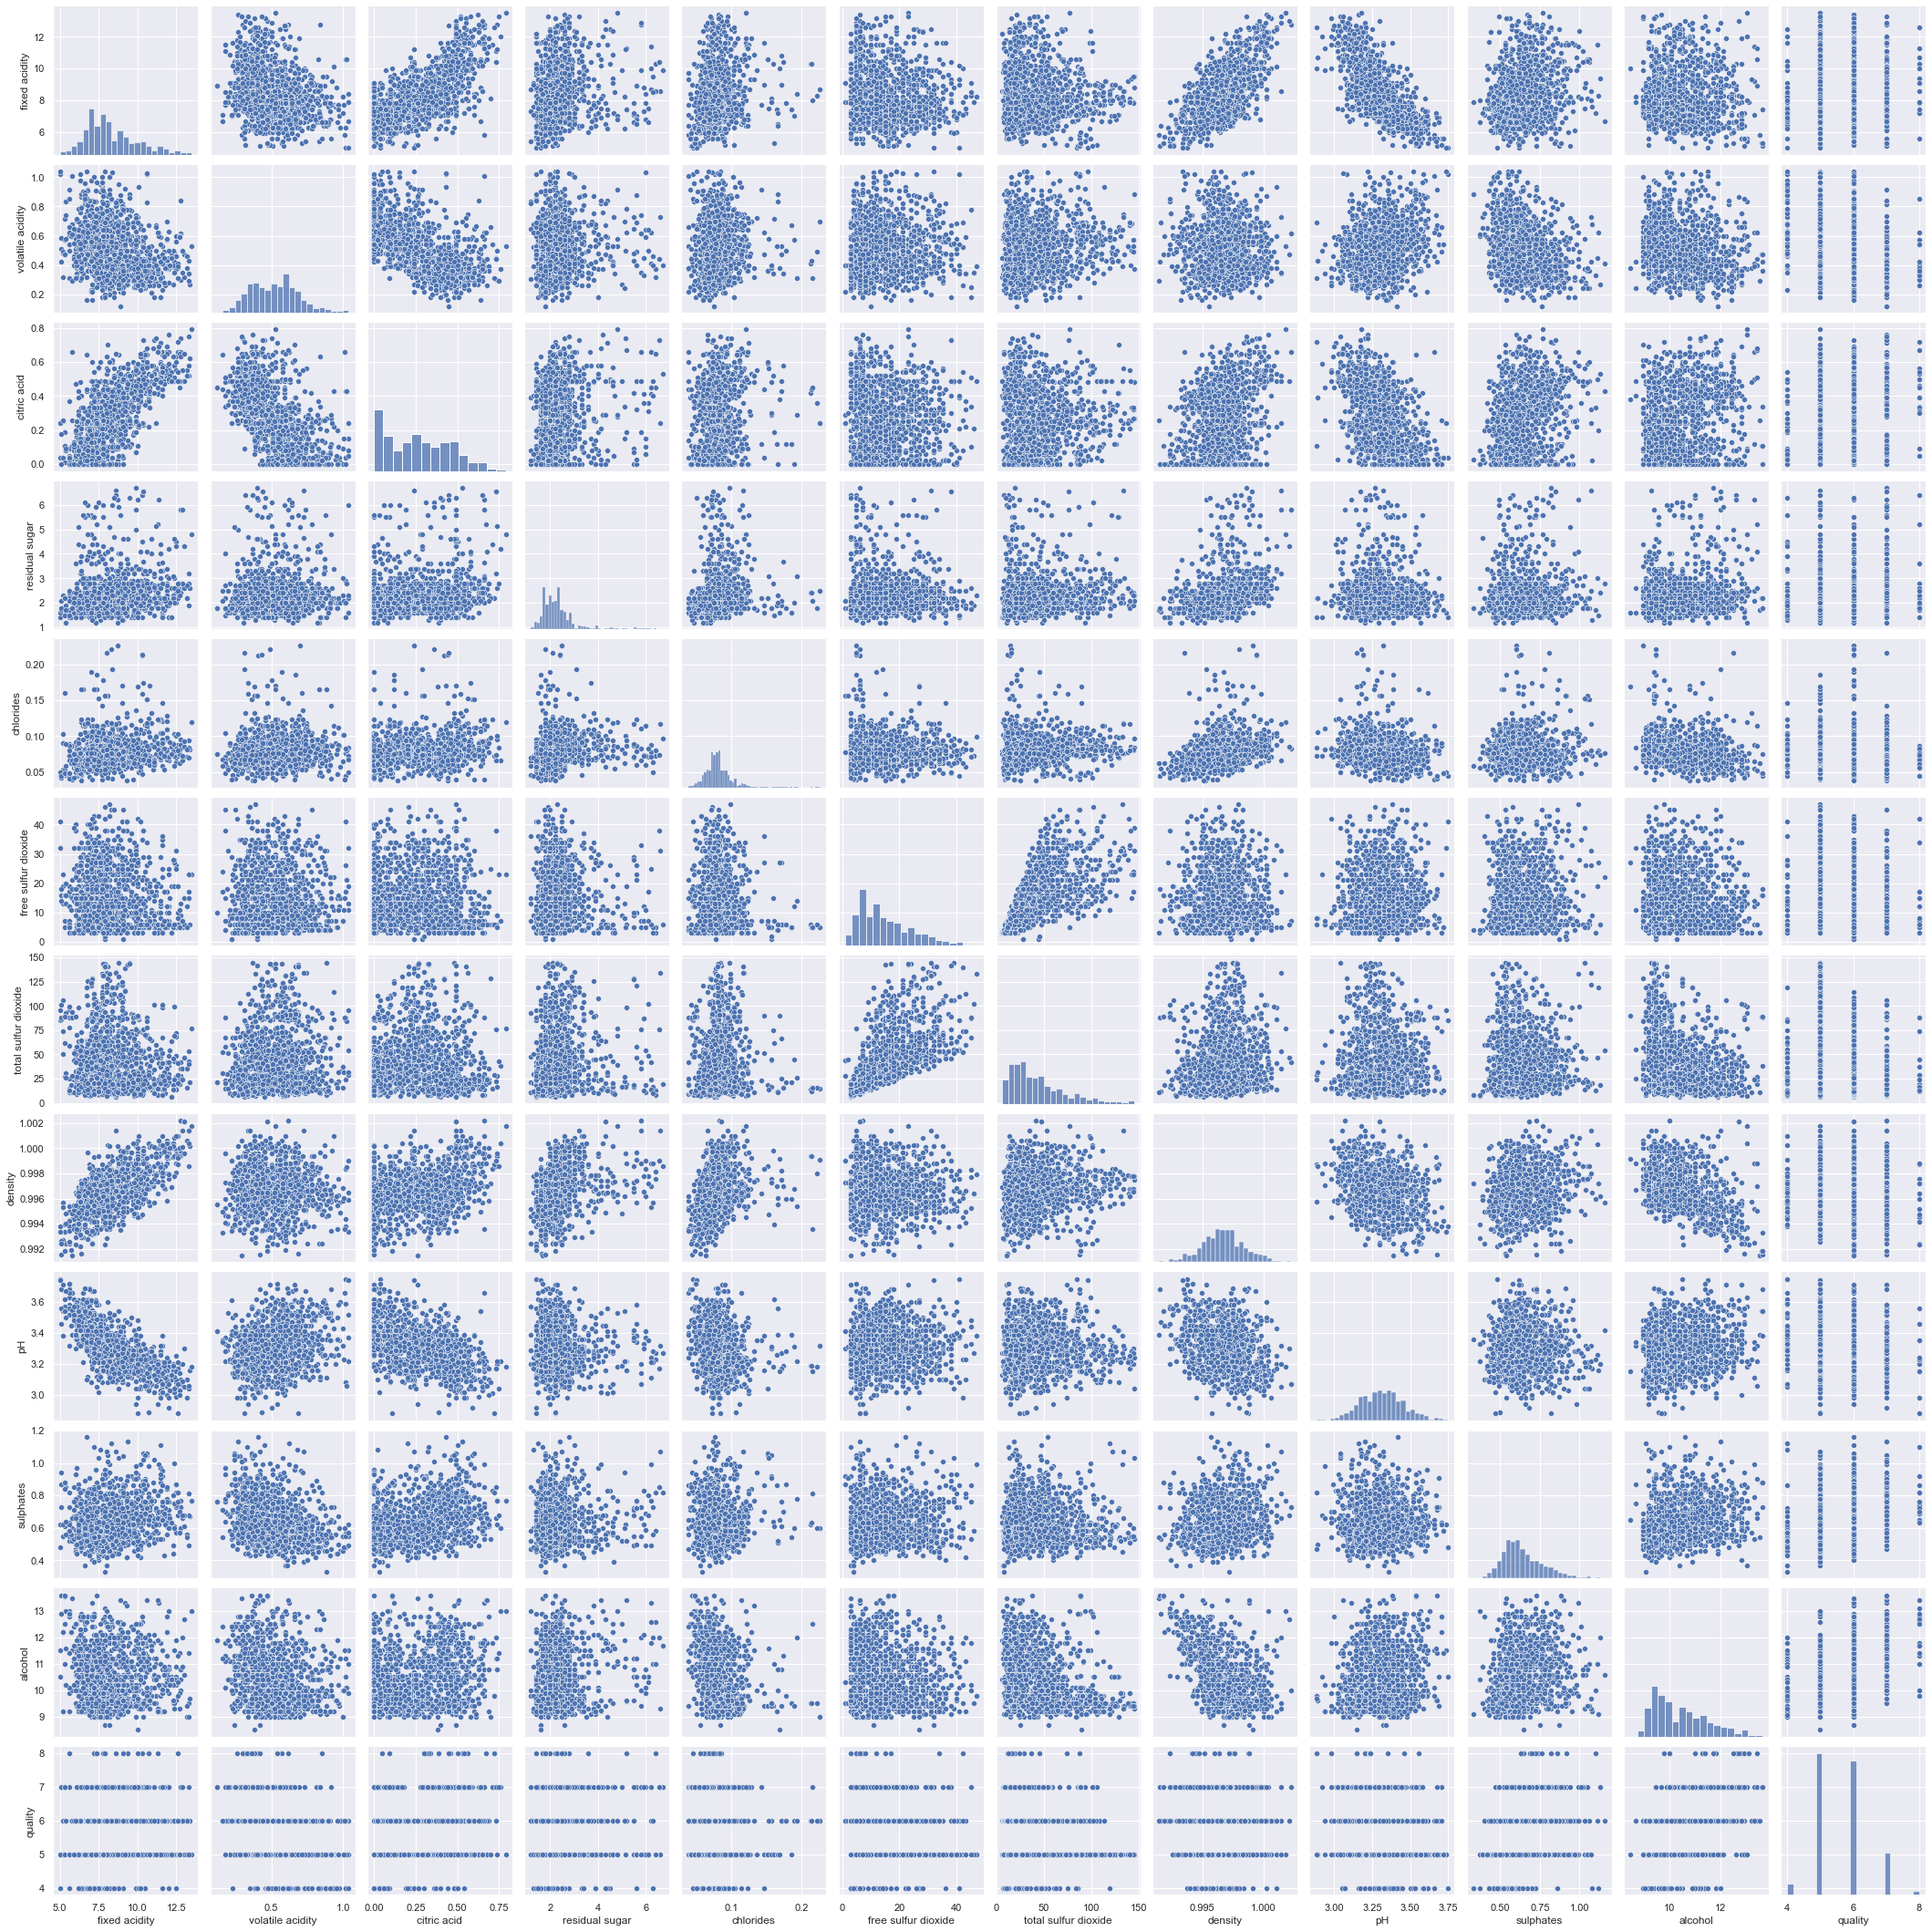

In [22]:
sns.pairplot(df_rm)
pass

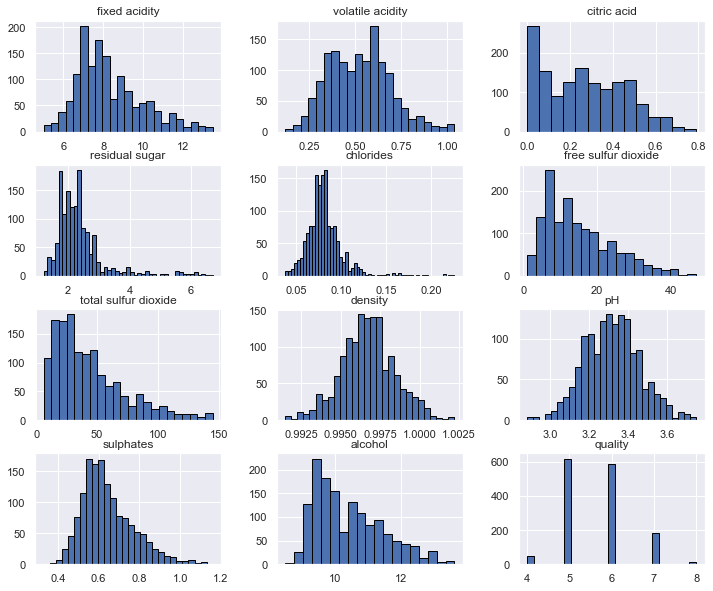

In [23]:
df_rm.hist(bins='auto', edgecolor='black',  
        figsize=(12,10));